In [1]:
import os
from PIL import Image, UnidentifiedImageError
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.utils as tu
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! gdown --id 11L00wufQ3htCw1hvnE6KjTiaeP1TLYUF

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=11L00wufQ3htCw1hvnE6KjTiaeP1TLYUF
From (redirected): https://drive.google.com/uc?id=11L00wufQ3htCw1hvnE6KjTiaeP1TLYUF&confirm=t&uuid=f8251a79-bdc2-4bcc-9d06-c08fd72a3fba
To: /content/Pet.zip
100% 172M/172M [00:02<00:00, 73.0MB/s]


In [4]:
ZipPath = "/content/Pet.zip"

In [5]:
import zipfile
import os


def extract_zip(zip_file_path, extract_to_dir):

    if not os.path.exists(zip_file_path):
        print(f"The zip file '{zip_file_path}' does not exist.")
        return


    if not os.path.exists(extract_to_dir):
        os.makedirs(extract_to_dir)


    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to_dir)
        print(f"Extracted '{zip_file_path}' to '{extract_to_dir}'.")


In [6]:
zip_file_path = '/content/Pet.zip'
extract_to_dir = '/content'


extract_zip(zip_file_path, extract_to_dir)

Extracted '/content/Pet.zip' to '/content'.


In [21]:
filepath = "/content/Pet"

transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])


In [22]:
corrupt_images = []

for subdir, dirs, files in os.walk(filepath):
    for file in files:
        file_path = os.path.join(subdir, file)
        try:
            with Image.open(file_path) as img:
                img.verify()
        except (UnidentifiedImageError, OSError, ValueError) as e:
            print(f"Corrupt or unreadable image: {file_path}. Error: {e}")
            corrupt_images.append(file_path)

if corrupt_images:
    print(f"\nFound {len(corrupt_images)} corrupt images:")
    for corrupt_file in corrupt_images:
        print(corrupt_file)
else:
    print("\nNo corrupt images found in the dataset.")

Corrupt or unreadable image: /content/Pet/Dog/Thumbs.db. Error: cannot identify image file '/content/Pet/Dog/Thumbs.db'

Found 1 corrupt images:
/content/Pet/Dog/Thumbs.db


In [23]:
valid_images = []
for subdir, dirs, files in os.walk(filepath):
    for file in files:
        file_path = os.path.join(subdir, file)
        if file_path not in corrupt_images:
            valid_images.append(file_path)

class FilteredImageFolder(torch.utils.data.Dataset):
    def __init__(self, valid_image_paths, transform=None):
        self.image_paths = valid_image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, 0

filtered_dataset = FilteredImageFolder(valid_images, transform=transform)
dataloader = DataLoader(filtered_dataset, batch_size=64, shuffle=True)

print(len(filtered_dataset))
print(dataloader)

4615


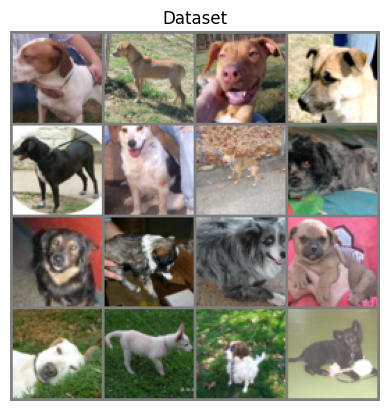

In [24]:
dataiter = iter(dataloader)
images, labels = next(dataiter)

img_grid = tu.make_grid(images[:16], nrow=4)

np_img = img_grid.numpy().transpose((1, 2, 0))

np_img = np_img / 2 + 0.5

plt.imshow(np_img)
plt.axis('off')
plt.grid(True)
plt.title('Dataset')
plt.savefig('dataset.jpg')
plt.show()


In [25]:
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_dim, in_dim // 8, 1)
        self.key_conv = nn.Conv2d(in_dim, in_dim // 8, 1)
        self.value_conv = nn.Conv2d(in_dim, in_dim, 1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        batch_size, C, width, height = x.size()
        proj_query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(batch_size, -1, width * height)
        energy = torch.bmm(proj_query, proj_key)
        attention = self.softmax(energy)
        proj_value = self.value_conv(x).view(batch_size, -1, width * height)
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)
        out = self.gamma * out + x
        return out

In [26]:
class SAGANGenerator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super(SAGANGenerator, self).__init__()
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(z_dim, features_g * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(features_g * 16),
            nn.ReLU(True),
            nn.ConvTranspose2d(features_g * 16, features_g * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g * 8),
            nn.ReLU(True),
            SelfAttention(features_g * 8),
            nn.ConvTranspose2d(features_g * 8, features_g * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(features_g * 4, channels_img, 4, 2, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.gen(x)

z_dim = 128
gen = SAGANGenerator(z_dim, channels_img=3, features_g=64)

print(gen)

SAGANGenerator(
  (gen): Sequential(
    (0): ConvTranspose2d(128, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): SelfAttention(
      (query_conv): Conv2d(512, 64, kernel_size=(1, 1), stride=(1, 1))
      (key_conv): Conv2d(512, 64, kernel_size=(1, 1), stride=(1, 1))
      (value_conv): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
      (softmax): Softmax(dim=-1)
    )
    (7): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): ConvTranspose2d(256, 3, kernel_size=(4, 4),

In [27]:
class SAGANDiscriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(SAGANDiscriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(channels_img, features_d, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            nn.Conv2d(features_d, features_d * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_d * 2),
            nn.LeakyReLU(0.2),
            SelfAttention(features_d * 2),
            nn.Conv2d(features_d * 2, 1, 4, 1, 0, bias=False),
        )

    def forward(self, x):
        return self.disc(x)


disc = SAGANDiscriminator(channels_img=3, features_d=64)

print(disc)


SAGANDiscriminator(
  (disc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): SelfAttention(
      (query_conv): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (key_conv): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (value_conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
      (softmax): Softmax(dim=-1)
    )
    (6): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)


In [31]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gen = SAGANGenerator(z_dim=128, channels_img=3, features_g=64).to(device)
disc = SAGANDiscriminator(channels_img=3, features_d=64).to(device)

num_epochs = 100

optimizer_gen = optim.Adam(gen.parameters(), lr=0.001, betas=(0.5, 0.999))
optimizer_disc = optim.Adam(disc.parameters(), lr=0.0001, betas=(0.5, 0.999))


criterion = nn.BCEWithLogitsLoss()


fixed_noise = torch.randn(64, 128, 1, 1).to(device)

real_label = 0.9
fake_label = 0.1

for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device)
        batch_size = real.size(0)
        noise = torch.randn(batch_size, 128, 1, 1).to(device)

        real_noise = real + 0.05 * torch.randn_like(real).to(device)

        fake = gen(noise)
        fake_noise = fake + 0.05 * torch.randn_like(fake).to(device)

        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.full_like(disc_real, real_label))

        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.full_like(disc_fake, fake_label))

        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        optimizer_disc.zero_grad()
        loss_disc.backward()
        optimizer_disc.step()

        if batch_idx % 2 == 0:
            output = disc(fake).reshape(-1)
            loss_gen = criterion(output, torch.ones_like(output))
            optimizer_gen.zero_grad()
            loss_gen.backward()
            optimizer_gen.step()


    print(f'Epoch [{epoch+1}/{num_epochs}] | Loss D: {loss_disc.item():.4f} | Loss G: {loss_gen.item():.4f}')


Epoch [1/100] | Loss D: 0.6317 | Loss G: 1.0110
Epoch [2/100] | Loss D: 0.5969 | Loss G: 0.9275
Epoch [3/100] | Loss D: 0.5428 | Loss G: 1.0678
Epoch [4/100] | Loss D: 0.5760 | Loss G: 1.1175
Epoch [5/100] | Loss D: 0.5336 | Loss G: 1.2399
Epoch [6/100] | Loss D: 0.4109 | Loss G: 1.8237
Epoch [7/100] | Loss D: 0.4643 | Loss G: 1.4804
Epoch [8/100] | Loss D: 0.3787 | Loss G: 1.7630
Epoch [9/100] | Loss D: 0.4761 | Loss G: 1.7528
Epoch [10/100] | Loss D: 0.4297 | Loss G: 1.5818
Epoch [11/100] | Loss D: 0.3736 | Loss G: 1.9498
Epoch [12/100] | Loss D: 0.3565 | Loss G: 2.1015
Epoch [13/100] | Loss D: 0.4279 | Loss G: 1.8098
Epoch [14/100] | Loss D: 0.3482 | Loss G: 2.4303
Epoch [15/100] | Loss D: 0.3755 | Loss G: 2.5296
Epoch [16/100] | Loss D: 0.3483 | Loss G: 2.5373
Epoch [17/100] | Loss D: 0.4369 | Loss G: 2.0702
Epoch [18/100] | Loss D: 0.3601 | Loss G: 2.2522
Epoch [19/100] | Loss D: 0.3373 | Loss G: 2.6037
Epoch [20/100] | Loss D: 0.4673 | Loss G: 1.9110
Epoch [21/100] | Loss D: 0.37

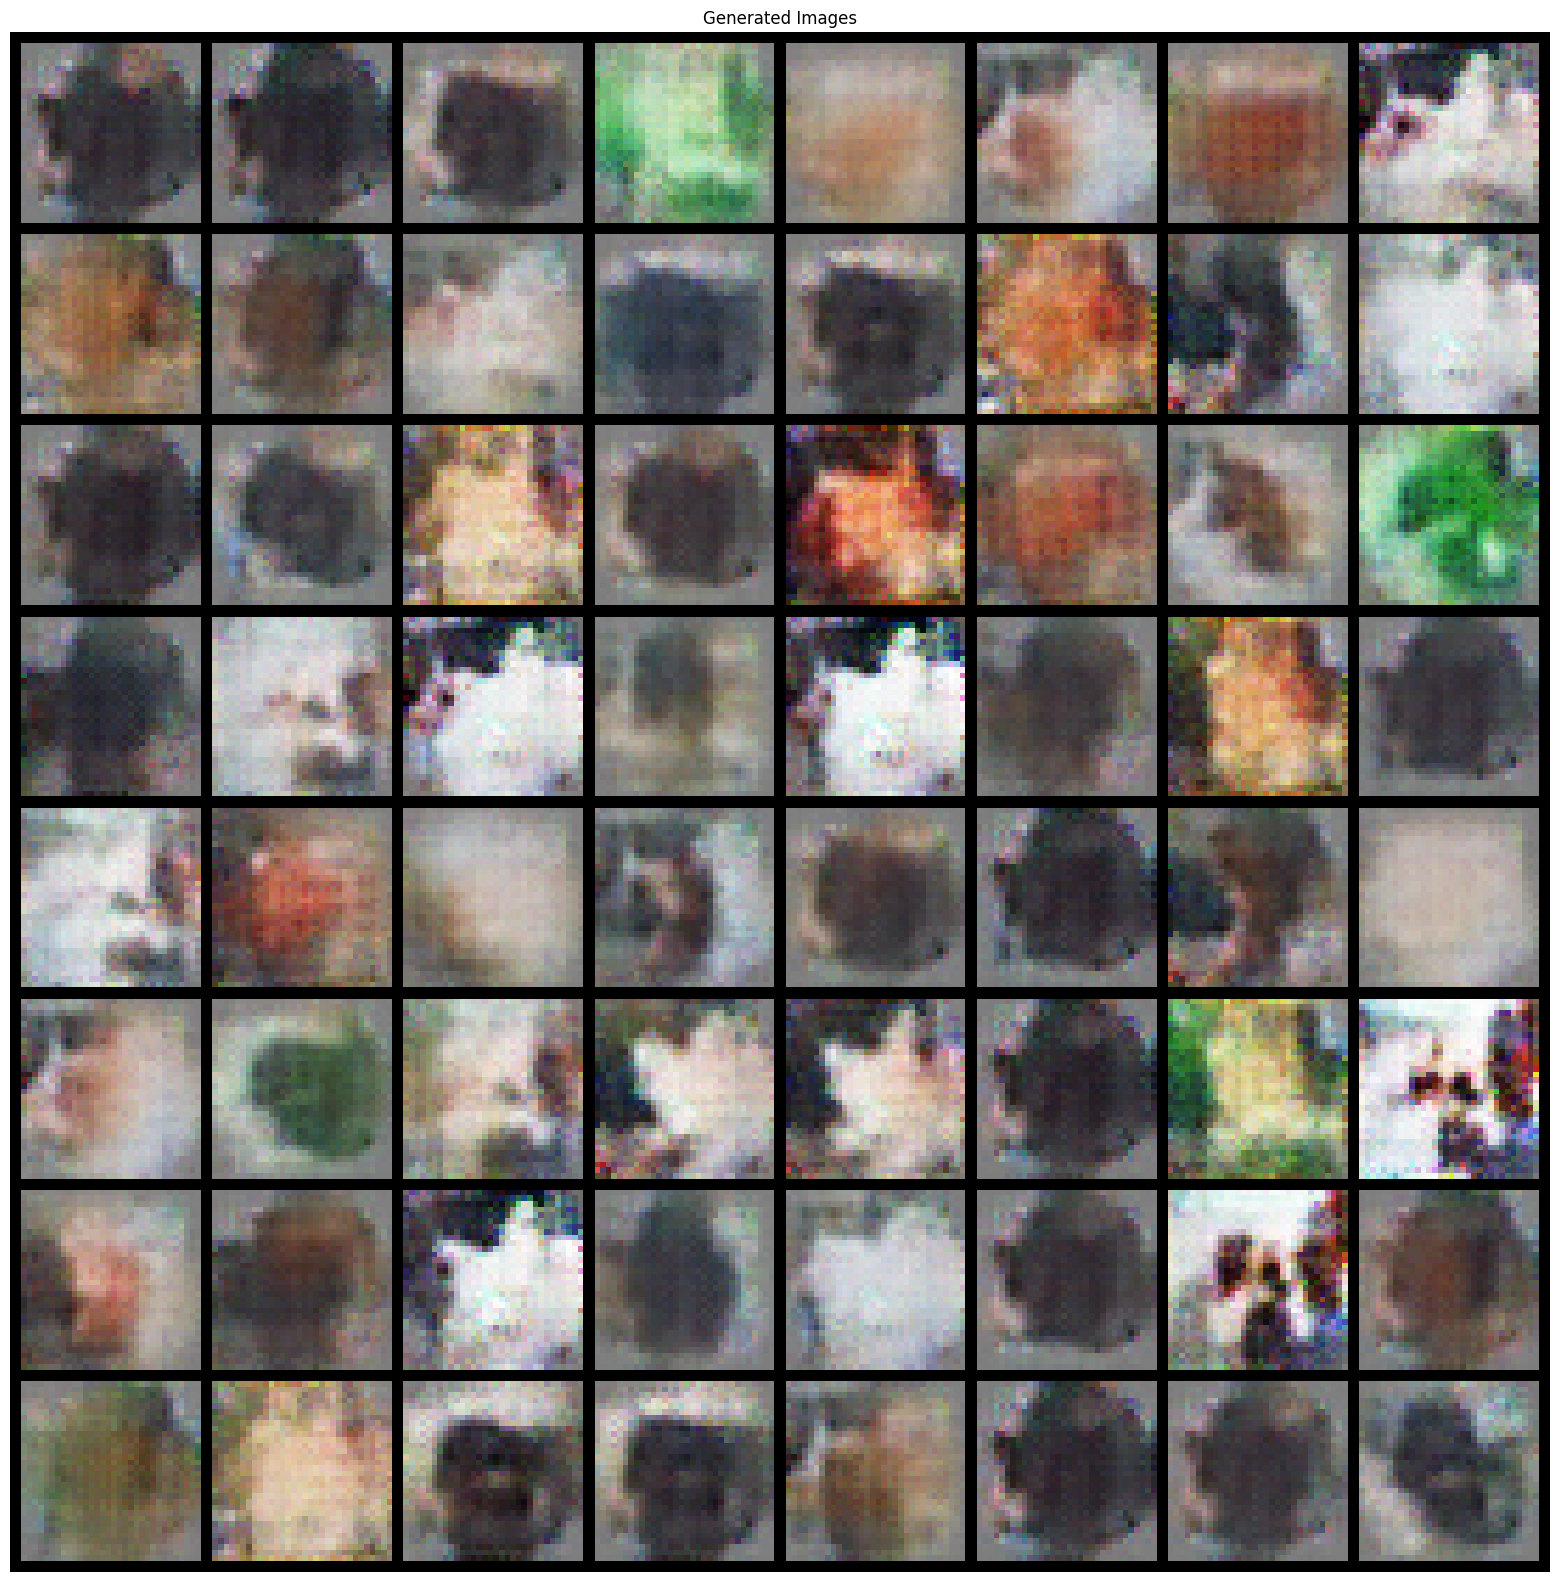

In [33]:
with torch.no_grad():
    fake = gen(fixed_noise).detach().cpu()
    plt.figure(figsize=(20, 20))
    plt.axis("off")
    plt.title("Generated Images")
    plt.imshow(np.transpose(tu.make_grid(fake, padding=2, normalize=True), (1, 2, 0)))
    plt.show()